# E2a: Küchentischversuch zum Laval-Rotor

Name:  Santiago Ramirez Saldana
Datum:  02.01-2024

## Forschungsfrage

Formulieren Sie eine oder mehrere Forschungsfragen zu der Lerneinheit: "Wie gut können die Schwingungen verschiedener Objekte vom Beschleunigungssensor empfangen werden"

# Erster Versuch
Hier werden Sie den ersten Gegenstand auswerten. Die Auswertung des zweiten Gegenstands kann das analog erfolgen, die entsprechenden jupyter-notebook-Zellen sind weiter unten vorbereitet.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

![JBL_Box.jpg](figures/JBL_Box.jpg)


Für das Experiment wird ein Objekt, das Vibrationen aussendet, den Beschleunigungssensor und den Raspberrypi benötigt.In diesem Fall wurde ein JBL-Musiklautsprecher, genauer gesagt der Charge 3, verwendet. Für den Versuch wird der Lautsprecher senkrecht aufgestellt, dann der Sensor auf die Membran gesetzt und mit Klebeband befestigt.Schließlich wird Musik aus dem Lautsprecher gespielt und das Experiment beginnt.

## Versuchsauswertung

Die Vermessung des Haushaltsgegenstands wird in diesem Notebook ausgewertet, dazu werden die drei Funktionen ```get_vec_accel()```, ```interpolation()``` und ```my_fft()``` in ```functions/m_postprocessing.py``` verwendet. Die Ein- und Ausgangsgrößen der Funktionen sind in ```functions/m_postprocessing.py``` definiert, bitte berücksichtigen Sie die vordefinierten Datentypen.


Alle Codeblöcke, in denen Sie Änderungen vornehmen müssen, sind nachfolgend markiert.

In [1]:
import h5py
import numpy as np
import json
import os

%matplotlib inline
import matplotlib.pyplot as plt

from functions.m_operate import evaluate_metadata

from functions.m_postprocessing import get_vec_accel
from functions.m_postprocessing import interpolation
from functions.m_postprocessing import my_fft

path = os.path.join("supplementary_code", "FST.mplstyle")
plt.style.use(path)

#### 1a. Einlesen der Mess- und Metadaten

In [2]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = "measurement_data/data_20240103_205320_SantiagoRamirezSaldana_JBL_Box" # replace None by the relative path to the first object's folder
h5_file_name = "data_20240103_205320_SantiagoRamirezSaldana_JBL_Box.h5" # replace None by the filename of the hdf5-file
# ---------------------------------------------------------------------------------------------#1-end

In [3]:
"""Prepare Metadata"""
(setup_json_dict, sensor_settings_dict, probe_name) = evaluate_metadata(
    path_measurement_folder
)

print(json.dumps(setup_json_dict, indent=2, default=str))
print(json.dumps(sensor_settings_dict, indent=2, default=str))
print("Probe: {}".format(probe_name))


{
  "1ee846ef-4df0-632a-bfdb-ef2ea3181b39": {
    "type": "general",
    "name": "general_info",
    "comment": "",
    "path": "measurement_data/data_20240103_205320_SantiagoRamirezSaldana_JBL_Box/1ee846ef-4df0-632a-bfdb-ef2ea3181b39.json"
  },
  "1ee846f1-b588-6d3c-9659-7c3266d530e8": {
    "type": "instrument",
    "name": "raspberry_pi",
    "comment": "",
    "path": "measurement_data/data_20240103_205320_SantiagoRamirezSaldana_JBL_Box/1ee846f1-b588-6d3c-9659-7c3266d530e8.json"
  },
  "1ee847be-fddd-6ee4-892a-68c4555b0981": {
    "type": "sensor",
    "name": "accelerometer",
    "range": {
      "min": -2,
      "max": 2,
      "units": "standard_gravity"
    },
    "frequency": {
      "value": 800,
      "units": "Hertz"
    },
    "comment": "",
    "path": "measurement_data/data_20240103_205320_SantiagoRamirezSaldana_JBL_Box/1ee847be-fddd-6ee4-892a-68c4555b0981.json"
  },
  "1ee99c82-3127-62f8-9c08-55322c3d5eaa": {
    "type": "probe",
    "name": "JBL_Box",
    "comment": ""

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [4]:
path_h5 = path_measurement_folder+"/"+h5_file_name
f = h5py.File(path_h5, 'r')       
data= f["RawData"]["1ee847be-fddd-6ee4-892a-68c4555b0981"]
acceleration_x = np.array(data['acceleration_x'])
acceleration_y = np.array(data['acceleration_y'])
acceleration_z = np.array(data['acceleration_z'])
time = np.array(data['timestamp'])

#### 2. Betrag der Beschleunigung berechnen

Die Messdaten des Beschleunigungssensors sind vektorielle Werte (```acc_x, acc_y, acc_z```). Berechnen Sie für jeden Zeitpunkt in ```vec_time``` den Betrag des Beschleunigungsvektors. Verwenden Sie dazu die Funktion ```get_vec_accel()```. In den folgenden Aufgaben wird der Betrag der Beschleunigung weiterverwendet.

In [5]:
absolut_acc = get_vec_accel(acceleration_x,acceleration_y, acceleration_z)
print(absolut_acc)

[11.92217636 11.97285541 11.97285541 ... 12.28199817 12.28199817
 12.28199817]


#### 3. Darstellung der Messdaten
Stellen Sie den Betrag der Beschleunigung über die Zeit und die zeitlichen Abstände zwischen den Messpunkten über die Zeit graphisch dar. Achten Sie dabei auf eine sinnvolle Achsenbeschriftung. 

In [6]:
plt.plot(time, absolut_acc)
plt.xlabel('Zeit in Sekunden')
plt.ylabel('Absolute Beschleunigung in m/s^2')

Text(0, 0.5, 'Absolute Beschleunigung in m/s^2')

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


#### 4. Interpolation der Messwerte

Da es sich beim Pi nicht um ein Echtzeit-Messsystem handelt, variieren die Zeitabstände zwischen den Messwerten. Da für die FFT äquidistante Messwerte benötigt werden, ist eine Interpolation der Daten erforderlich.

In [7]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.
interpolationszeit, interpolationspunkte = interpolation(time, absolut_acc)

#### 5 & 6. FFT durchführen und graphisch darstellen

Transformieren Sie die interpolierten Beträge der Beschleunigung mit der Funktion ```my_fft()``` in den Frequenzraum. Eine Skalierung der Amplitude der FFT ist nicht notwendig.
Stellen Sie die Amplitude des Signals als Funktion der Frequenz graphisch dar.

Text(0, 0.5, 'Amplitude')

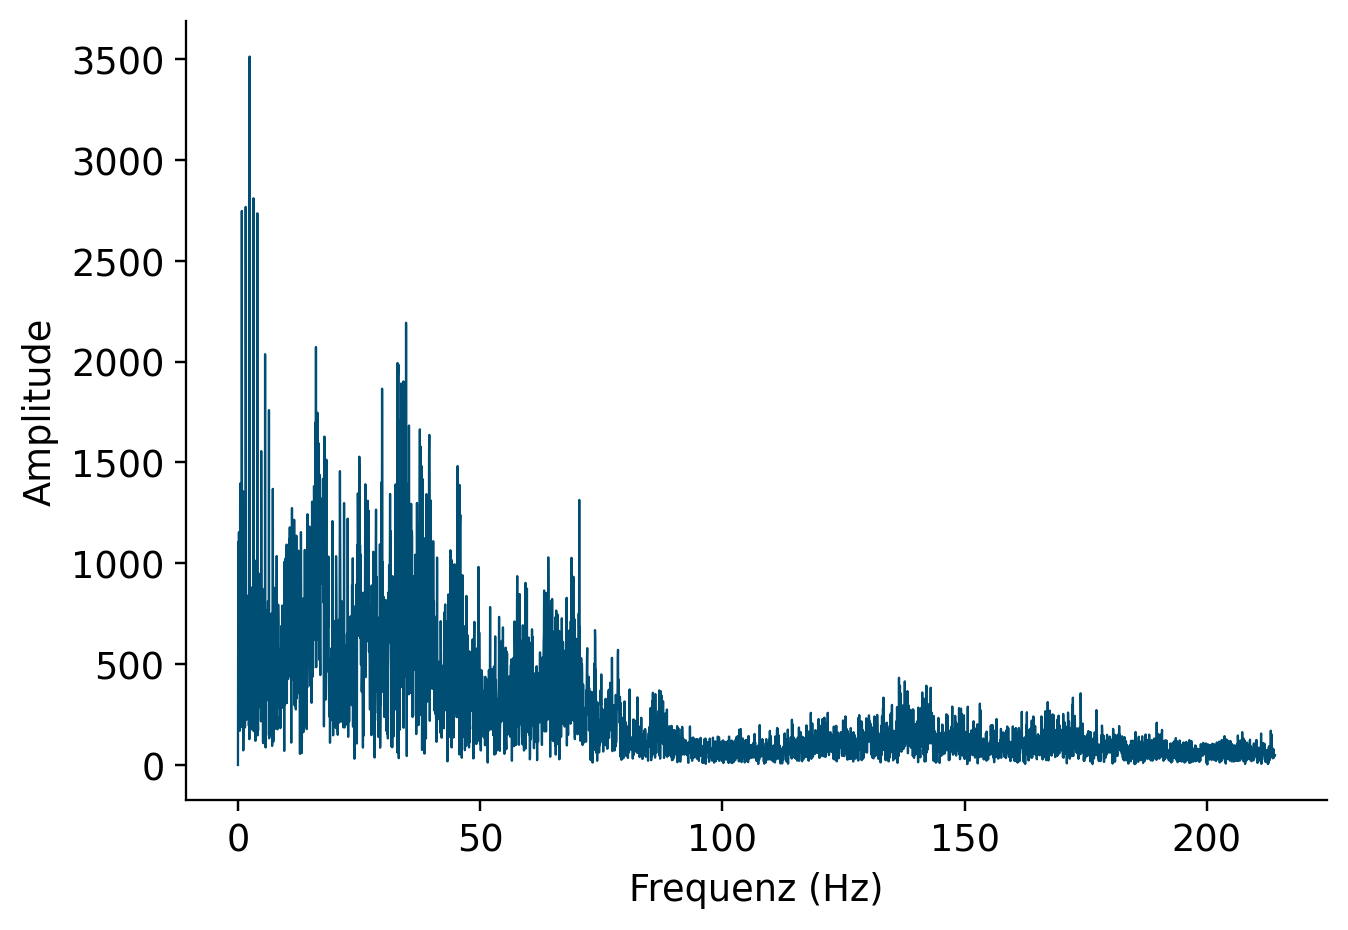

In [8]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.
amplitude, frequency = my_fft(interpolationspunkte, interpolationszeit)

plt.plot(frequency, np.abs(amplitude))
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Amplitude')
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Zweiter Versuch
Hier werten Sie den zweiten Gegenstand aus.

##  Versuchsaufbau und -durchführung

Beachten Sie, dass Sie den Code zum Auslesen des Beschleunigungssensor ausschließlich mit dem Raspberry Pi ausführen können.

- Bild von Aufbau des Haushaltsgegenstands:

![Handy.jpg](figures/Handy.jpg)

Für das Experiment wird ein Objekt, das Vibrationen aussendet, den Beschleunigungssensor und den Raspberrypi benötigt.In diesem Fall wurde ein Handy, genauer gesagt der Samsung Galaxy S9, verwendet. Für den Versuch wird das Handy auf den Tisch aufgestellt, dann der Sensor auf das Handy gesetzt und mit Klebeband befestigt. Schließlich wird ein Wecker eingestellt und sobald der Wecker klingelt, beginnt das Experiment.

#### 1a. Einlesen der Mess- und Metadaten

In [15]:
"""Parameter definition"""
# -------------------------------------------------------------------------------------------#1-start
# TODO: Adjust the parameters to your needs. Please use relative paths!
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
path_measurement_folder = "measurement_data/data_20240103_210416_SantiagoRamirezSaldana_Handy" # replace None by the relative path to the first object's folder
h5_file_name = "data_20240103_210416_SantiagoRamirezSaldana_Handy.h5" # replace None by the filename of the hdf5-file
# ---------------------------------------------------------------------------------------------#1-end

#### 1b. Auslesen der Beschleunigungen und der Zeit in numpy-arrays

In [10]:
path_h5 = path_measurement_folder+"/"+h5_file_name
f = h5py.File(path_h5, 'r')       
data= f["RawData"]["1ee847be-fddd-6ee4-892a-68c4555b0981"]
acceleration_x = np.array(data['acceleration_x'])
acceleration_y = np.array(data['acceleration_y'])
acceleration_z = np.array(data['acceleration_z'])
time = np.array(data['timestamp'])

#### 2. Betrag der Beschleunigung berechnen


In [11]:
absolut_acc = get_vec_accel(acceleration_x,acceleration_y, acceleration_z)
print(absolut_acc)

[11.69834288 11.6949225  11.6949225  ... 10.09534485 10.09534485
 10.09534485]


#### 3. Darstellung der Messdaten

Text(0, 0.5, 'Absolute Beschleunigung in m/s^2')

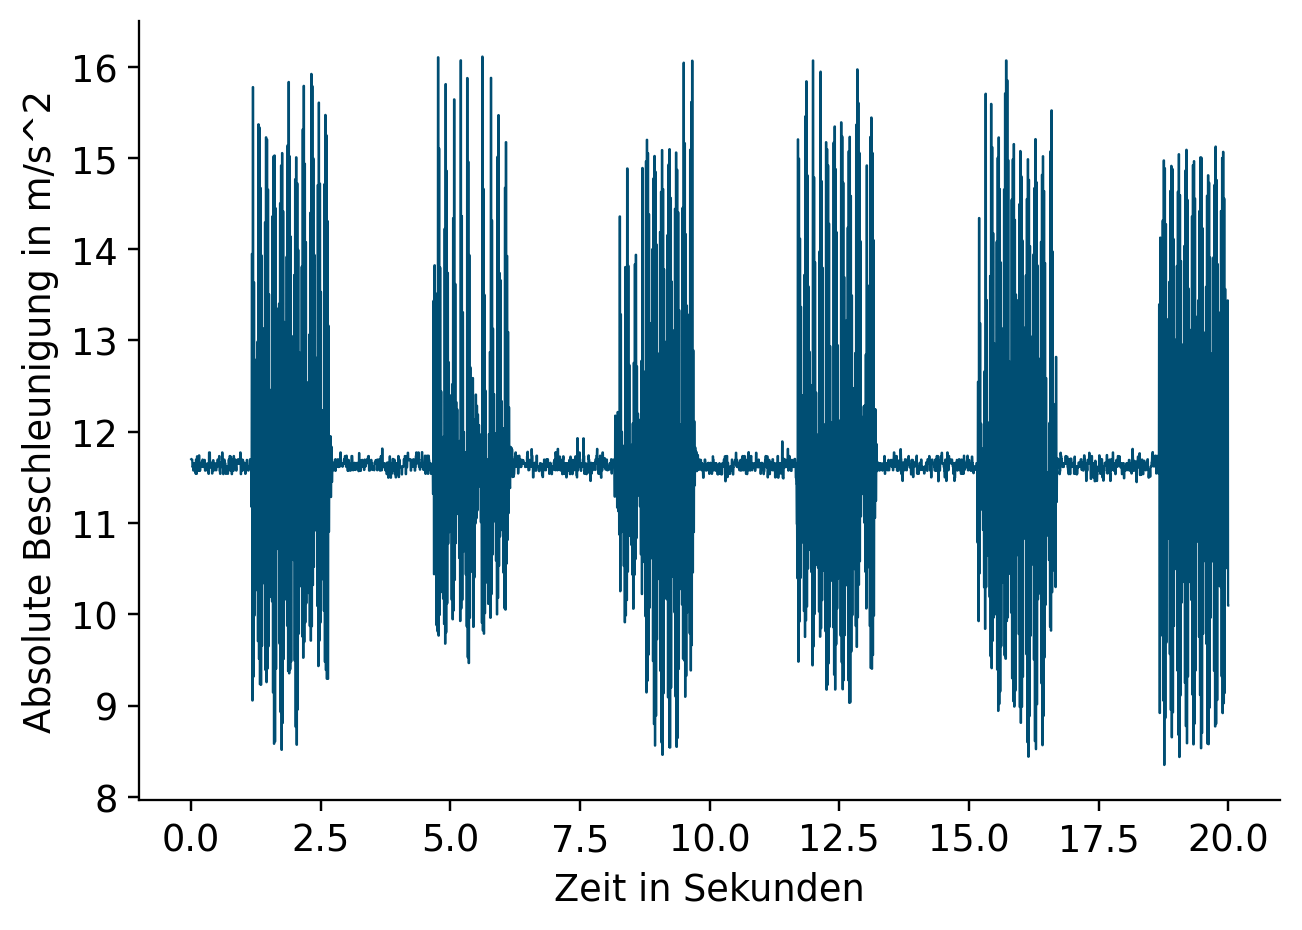

In [12]:
plt.plot(time, absolut_acc)
plt.xlabel('Zeit in Sekunden')
plt.ylabel('Absolute Beschleunigung in m/s^2')

#### 4. Interpolation der Messwerte



In [13]:
# -------------------------------------------------------------------------------------------#4-start
# TODO: Write the function interpolation() (in m_postprocessing) to linearly interpolate the
# acceleration.
interpolationszeit, interpolationspunkte = interpolation(time, absolut_acc)

#### 5 & 6. FFT durchführen und graphisch darstellen


In [14]:
# -------------------------------------------------------------------------------------------#5-start
# TODO: Write my_fft() (in m_postprocessing) and plot results.
amplitude, frequency = my_fft(interpolationspunkte, interpolationszeit)

plt.plot(frequency, np.abs(amplitude))
plt.xlabel('Frequenz (Hz)')
plt.ylabel('Amplitude')
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

Text(0, 0.5, 'Amplitude')

## Diskussion
Diskutieren Sie die Ergebnisse Ihrer Experimente aus wissenschaftlicher Sicht, gehen Sie dabei insbesondere auch auf die zu Beginn aufgestellte Forschungsfrage ein. Beispielsweise können Sie hier auf Einschränkungen der Aussagekraft der Ergebnisse eingehen.

Wie im ersten Versuch zu sehen ist, liegt der Höchstwert bei etwa 35 m^2/s und der Durchschnittswert bei etwa 12 m^2/s. Im zweiten Versuch ist ein Maximum von 16 m^2/s und ein Durchschnitt von 11,5 m^2/s zu erkennen. 
Vor dem Versuch kann man vermuten, dass die Schwingungen des Lautsprechers höher sein werden als die des Handys. Dies kann durch die oben genannten Werte bewiesen werden. Das Diagramm des ersten Experiments zeigt ein unregelmäßiges Beschleunigungsmuster mit unterschiedlichen Höhen und Tiefen, was bei einem Lautsprecher, der Musik abspielt, zu erwarten ist. Das zweite Diagramm zeigt ein symmetrisches Beschleunigungsmuster mit einer Zeitspanne mit Schwingungen um 15 m^2/s und Zeiten, in denen das Handy mit 11 m^2/s ruhiger ist und nicht schwingt. Die 11 m^2/s des ruhigen Zustands werden durch externe Quellen erklärt. Das Handy lag während des Experiments auf dem Tisch neben einem Computer, was möglicherweise Vibrationen während der Ruhephase verursacht hat.Unter Berücksichtigung der oben genannten Aspekte und Punkte wird gefolgert, dass die Ergebnisse des Experiments vertrauenswürdig sind und verwendet werden können, solange die Störgrößen korrigiert werden, um fehlerhafte Daten zu vermeiden.

## Fazit
Ziehen Sie ein Fazit zum durchgeführten Versuch, gehen Sie dabei gerne auf Ihrer persönliche Meinung oder Ihre Lernziele ein.

Das Experiment war insgesamt recht interessant. Ich habe gelernt, dass man, um fehlerhafte Ergebnisse zu vermeiden, mehr als ein Experiment durchführen und nach möglichen Störgroßen suchen sollte. Auch wenn die Ergebnisse nicht exakt und wahrscheinlich nicht ganz korrekt waren, kann ich sagen, dass das Experiment erfolgreich war.